<div id="container" style="position:relative;">
<div style="float:left"><h1> Capstone Project: Diabetes risk predictor based on health indicators</h1></div>
<div style="float:left"><h2> Notebook 4: # Modelling - Logistics Regression models</h2></div>
<div style="float:left"><h2> Created by Diego Villanueva</h2></div>
</div>
</div>

This notebook includes  logistc models that use unmodified and oversampled training datasets.

## Table of contents

4.1 Load data files

4.2 Logistic regression function

4.3 Using unmodified dataset to train model

4.4 Model evaluation (unmodified)

4.5 Using oversampled dataset to train model

4.6 Model evaluation (oversampled)

### Imports

In [35]:
# data manipulation
import numpy as np
import pandas as pd

# plotting
import matplotlib.pyplot as plt
import seaborn as sns

# modelling
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report

# Scaling data
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler

# PCA
from sklearn.decomposition import PCA

# File saving
import joblib 
import pickle

# Temporary directories for caching
from tempfile import mkdtemp

# Cross-validation
from sklearn.model_selection import cross_val_score

# Pipeline building
from sklearn.pipeline import Pipeline

# Grid search
from sklearn.model_selection import GridSearchCV

%config InlineBackend.figure_format="retina"

### 4.1 Load data files

In [4]:
X_rem = joblib.load("../data/Preprocessed_data/X_rem.pkl") # Unmodified dataset
y_rem = joblib.load("../data/Preprocessed_data/y_rem.pkl") # Unmodified dataset

X_rem_os = joblib.load("../data/Preprocessed_data/X_rem_oversampled.pkl") # Over sampled dataset
y_rem_os = joblib.load("../data/Preprocessed_data/y_rem_oversampled.pkl") # Over sampled dataset

X_test = joblib.load("../data/Preprocessed_data/X_test.pkl") # not scaled dataset
y_test = joblib.load("../data/Preprocessed_data/y_test.pkl") #unmodified dataset

### 4.2 Logistic regression function

In [5]:
def log_reg_function(X_train, y_train, X_test, y_test, c_values=None, cv=5, verbose=1, random_state=1):

    # Create a directory that will be used to cache the pipeline results
    cachedir = mkdtemp()

    # C values that will be used if no attribute provided
    if c_values is None:
        c_values = [.0001, .001, .1, 1, 10, 100, 1000]

    # Setup Pipeline
    my_pipeline = Pipeline([('scaler', StandardScaler()), 
                            ('dim_reducer', PCA()), 
                            ('model', LogisticRegression())], 
                            memory=cachedir)

    # Parameter grid
    log_reg_param_grid = [

    # l1 without PCA
    {'scaler': [None, StandardScaler(), MinMaxScaler(), RobustScaler()],
     'dim_reducer': [None],
     'model': [LogisticRegression(penalty='l1', random_state=1, max_iter=10000, solver='liblinear')],
     'model__C': c_values},
    
    # l2 (default) without PCA
    {'scaler': [None, StandardScaler(), MinMaxScaler(), RobustScaler()],
     'dim_reducer': [None],
     'model': [LogisticRegression(solver='lbfgs', random_state=1, n_jobs=-1, max_iter=10000)],
     'model__C': c_values}
]

    # Instantiate logistic regression with grid search
    logreg_gs = GridSearchCV(my_pipeline, param_grid=log_reg_param_grid, cv=cv, n_jobs=-1, verbose=verbose, refit=True)

    # Fit the logistic regression with grid search
    fitted_logreg_gs = logreg_gs.fit(X_train, y_train)

    # Accuracy of the model
    accuracy_remainder = fitted_logreg_gs.score(X_train, y_train)
    accuracy_test = fitted_logreg_gs.score(X_test, y_test)
    print("Accuracies of the optimized model:")
    print(f"The best logistic regression's accuracy on the training set: {accuracy_remainder}")
    print(f"The best logistic regression's accuracy on the test set: {accuracy_test}")

    # Return the best estimator and accuracy scores
    return {
        'best_estimator': fitted_logreg_gs.best_estimator_,
        'accuracy_train': accuracy_remainder,
        'accuracy_test': accuracy_test,
        'fitted_gs': fitted_logreg_gs
    }

### 4.3 Using unmodified dataset to train model

In [6]:
# Fit unmodified dataset
unmodified_results = log_reg_function(X_rem, y_rem, X_test, y_test)

Fitting 5 folds for each of 56 candidates, totalling 280 fits


Accuracies of the optimized model:
The best logistic regression's accuracy on the training set: 0.8488140289228274
The best logistic regression's accuracy on the test set: 0.8464863870493009


In [7]:
unmodified_results['best_estimator']

Pipeline(memory='/var/folders/6c/0s0k1hv53xn7g3bpzkggst1r0000gn/T/tmppx5hwcu7',
         steps=[('scaler', StandardScaler()), ('dim_reducer', None),
                ('model',
                 LogisticRegression(C=0.001, max_iter=10000, n_jobs=-1,
                                    random_state=1))])

In [14]:
# Test Code: The following code can be used to predict probabilities of a single row of the dataset, or the data of a single patient

sample_df = X_test.iloc[[0]]
proba_predicted = unmodified_results['best_estimator'].predict_proba(sample_df)
print(proba_predicted)



[[0.70642926 0.29357074]]


In [15]:
# Get coefficients and intercept from the model
best_model = unmodified_results['best_estimator'].named_steps['model']
coefficients = best_model.coef_.flatten()
intercept = best_model.intercept_

In [16]:
# Get names of columns 
feature_names = X_rem.columns 

# Create dataframe with features and their coefficient values
features_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})

# Sort rows based on the coefficient value
sorted_features_df = features_df.sort_values(by='Coefficient', ascending=False)

# Display the DataFrame
print(sorted_features_df)

                   Feature  Coefficient
13    General_health_score     0.485058
3                      BMI     0.394968
17                     Age     0.356234
0              Has_high_bp     0.348165
1     Has_high_cholesterol     0.286996
2      Checked_cholesterol     0.197975
16                 Is_male     0.112081
6        Has_heart_disease     0.065032
15      Walking_difficulty     0.041832
5               Had_stroke     0.021198
11      Has_healthcare_cov     0.012940
12    No_attention_bc_cost     0.012608
4                Is_smoker    -0.003185
9             Eats_veggies    -0.016259
14  Mental_health_bad_days    -0.021505
8              Eats_fruits    -0.021847
7        Physical_activity    -0.021948
18               Education    -0.052686
19                  Income    -0.112485
10           Heavy_drinker    -0.137798


In [17]:
# Get the top and bottom coefficients
low_5_coef = sorted_features_df.head(5)
high_5_coef = sorted_features_df.tail(5)

# Join them
combined_coef = pd.concat([low_5_coef, high_5_coef])

# Display results
print("Top 5 coefficients with the lowest values and top 5 with the highest values are:")
print(combined_coef)

Top 5 coefficients with the lowest values and top 5 with the highest values are:
                 Feature  Coefficient
13  General_health_score     0.485058
3                    BMI     0.394968
17                   Age     0.356234
0            Has_high_bp     0.348165
1   Has_high_cholesterol     0.286996
8            Eats_fruits    -0.021847
7      Physical_activity    -0.021948
18             Education    -0.052686
19                Income    -0.112485
10         Heavy_drinker    -0.137798


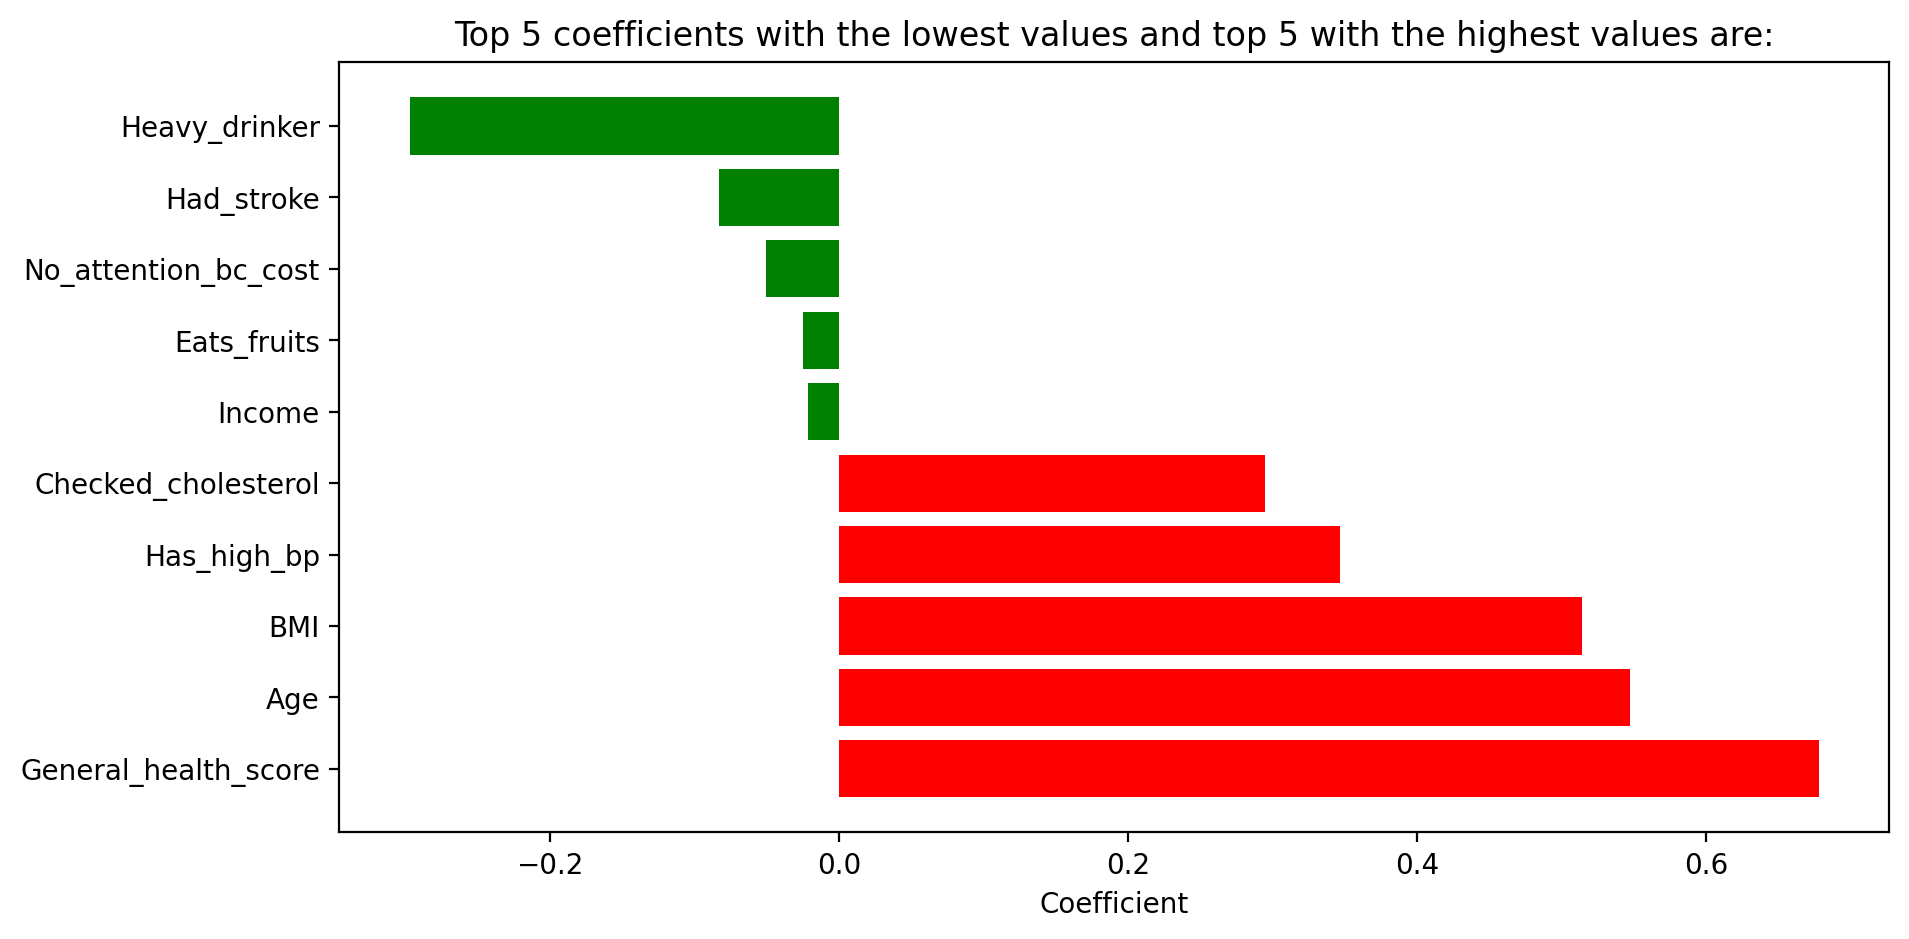

In [37]:
# Create a visualisation:
# Assign colors based on 'Coefficient' values
colors = ['green' if x < 0 else 'red' for x in combined_coef['Coefficient']]

# Create barh plot
plt.figure(figsize=(10, 5))
plt.barh(combined_coef['Feature'], combined_coef['Coefficient'], color=colors)
plt.xlabel('Coefficient')
plt.title('Top 5 coefficients with the lowest values and top 5 with the highest values are:')

# Add the values to the bars
for index, value in enumerate(combined_coef['Coefficient']):
    if value < 0:
        plt.text(value, index, f'{value:.2f}', va='center', ha='right', color='white')
    else:
        plt.text(value, index, f'{value:.2f}', va='center', ha='left', color='white')

# Show the plot
plt.show()

### 4.4 Model evaluation (unmodified)

In [19]:
# Create confusion matrix for logistic regression

# Get class predictions
y_pred = unmodified_results['best_estimator'].predict(X_test)

# Generate confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred)

# label rows and columns
cf_df = pd.DataFrame(
    cf_matrix, 
    columns=["Predicted Negative Diagnosis", "Predicted Positive Diagnosis"],
    index=["True Negative Diagnosis", "True Positive Diagnosis"]
)

display(cf_df)

,Predicted Negative Diagnosis,Predicted Positive Diagnosis
True Negative Diagnosis,62372,1739
True Positive Diagnosis,9944,2049


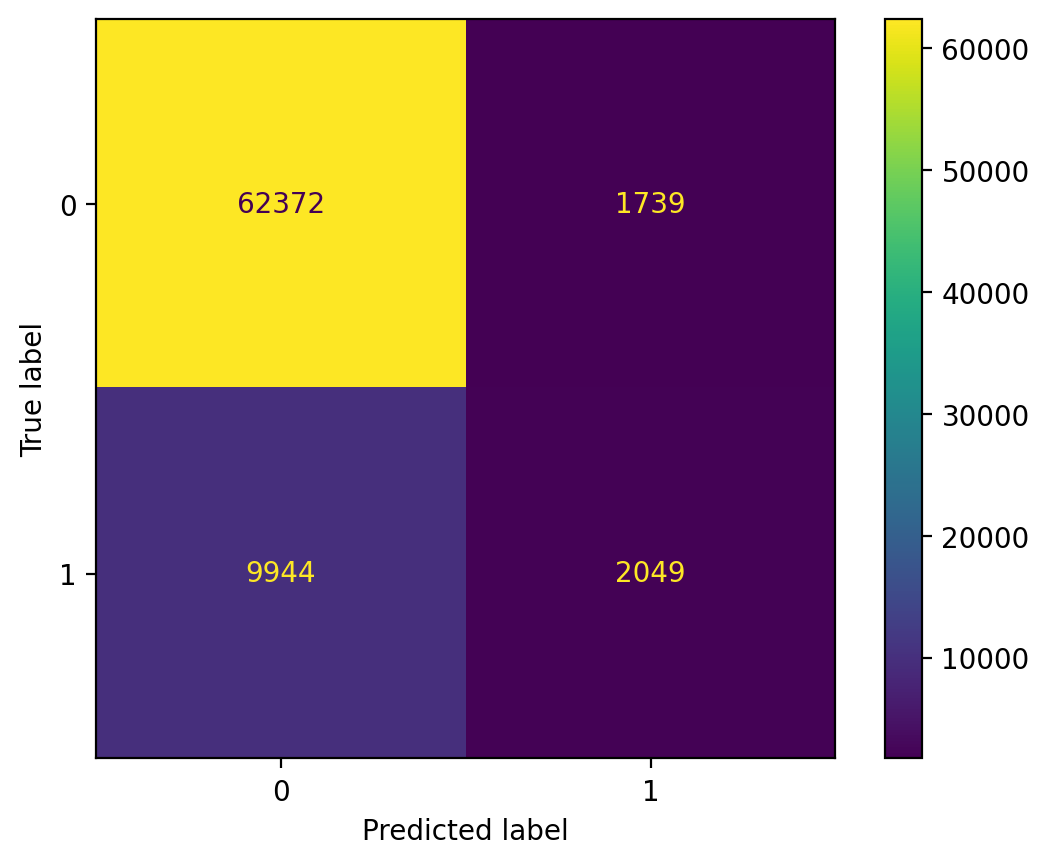

In [36]:
# Create visualisation of confusion matrix
ConfusionMatrixDisplay.from_estimator(unmodified_results['best_estimator'], X_test, y_test);

Interpretation:

    The results of the confusion matrix are as follows:

    True Negative:  62,372

    False Positive: 1,739

    False Negative: 9,944

    True Positive:  2.049

In [21]:
# Classification Report
report_initial = classification_report(y_test, y_pred)
print(report_initial)

              precision    recall  f1-score   support

           0       0.86      0.97      0.91     64111
           1       0.54      0.17      0.26     11993

    accuracy                           0.85     76104
   macro avg       0.70      0.57      0.59     76104
weighted avg       0.81      0.85      0.81     76104



Looking at the errors:

For 0: 
- The precision of 0.86 means that 14% of the predicitons as not having diabetes were in fact positive.
- The recall of 0.97 means that 3% of the negative diagnosis were missed by the model as they were classified as being positive

For 1: 
- The precision of 0.54 means that 46% of the predicitons as having diabetes were in fact negative 
- The recall of 0.17 indicates that 83% of the diagnosis that were positive  were missed by the model and were classified as being negative for diabetes



The model shows a very low F1 score of 0.26, indicating that the balance between recall and precision across the various classes could be improved. 

To improve the model's performance, it is recommended to closely examine instances where the sentiment was incorrectly predicted. 

Analysing these examples can help identify if there are specific health indicators that were mistakenly omitted, which could lead to more accurate predictions in the future.

### 4.5 Using oversampled dataset to train model

In [22]:
# Fit oversampled dataset
oversampled_results = log_reg_function(X_rem_os, y_rem_os, X_test, y_test)

Fitting 5 folds for each of 56 candidates, totalling 280 fits


Accuracies of the optimized model:
The best logistic regression's accuracy on the training set: 0.7599671105406707
The best logistic regression's accuracy on the test set: 0.7260853568800588


In [23]:
# Get coefficients and intercept from the model
best_model = oversampled_results['best_estimator'].named_steps['model']
coefficients = best_model.coef_.flatten()
intercept = best_model.intercept_

In [30]:
# Test Code: The following code can be used to predict probabilities of a single row of the dataset, or the data of a single patient

sample_df = X_test.iloc[[0]]
proba_predicted = oversampled_results['best_estimator'].predict_proba(sample_df)
print(proba_predicted)


[[0.2657282 0.7342718]]


In [34]:
# Save the model as a pkl file
pickle.dump(oversampled_results['best_estimator'], open('../model/log-reg-best-model.pkl', 'wb'))

In [24]:
# Get names of columns 
feature_names = X_rem_os.columns 

# Create dataframe with features and their coefficient values
features_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})

# Sort rows based on the coefficient value
sorted_features_df = features_df.sort_values(by='Coefficient', ascending=False)

# Display the DataFrame
print(sorted_features_df)

                   Feature  Coefficient
13    General_health_score     0.678084
17                     Age     0.547464
3                      BMI     0.514376
0              Has_high_bp     0.346835
2      Checked_cholesterol     0.294738
1     Has_high_cholesterol     0.285374
11      Has_healthcare_cov     0.110914
16                 Is_male     0.094673
4                Is_smoker     0.001360
15      Walking_difficulty     0.000000
18               Education     0.000000
6        Has_heart_disease     0.000000
7        Physical_activity     0.000000
9             Eats_veggies     0.000000
14  Mental_health_bad_days     0.000000
19                  Income    -0.021305
8              Eats_fruits    -0.024893
12    No_attention_bc_cost    -0.050112
5               Had_stroke    -0.082603
10           Heavy_drinker    -0.296668


In [25]:
# Get the top and bottom coefficients
low_5_coef = sorted_features_df.head(5)
high_5_coef = sorted_features_df.tail(5)

# Join them
combined_coef = pd.concat([low_5_coef, high_5_coef])

# Display results
print("Top 5 coefficients with the lowest values and top 5 with the highest values are:")
print(combined_coef)

Top 5 coefficients with the lowest values and top 5 with the highest values are:
                 Feature  Coefficient
13  General_health_score     0.678084
17                   Age     0.547464
3                    BMI     0.514376
0            Has_high_bp     0.346835
2    Checked_cholesterol     0.294738
19                Income    -0.021305
8            Eats_fruits    -0.024893
12  No_attention_bc_cost    -0.050112
5             Had_stroke    -0.082603
10         Heavy_drinker    -0.296668


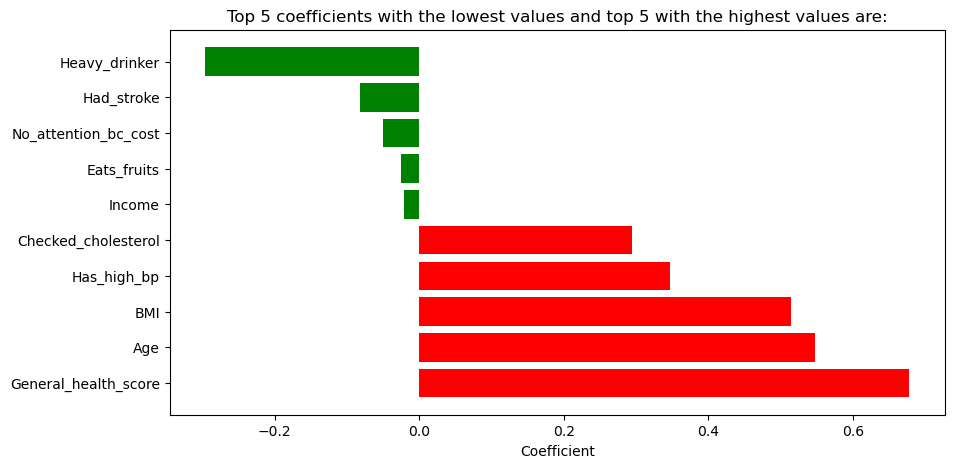

In [26]:
# Create a visualisation:
# Assign colors based on 'Coefficient' values
colors = ['green' if x < 0 else 'red' for x in combined_coef['Coefficient']]

# Create barh plot
plt.figure(figsize=(10, 5))
plt.barh(combined_coef['Feature'], combined_coef['Coefficient'], color=colors)
plt.xlabel('Coefficient')
plt.title('Top 5 coefficients with the lowest values and top 5 with the highest values are:')

# Add the values to the bars
for index, value in enumerate(combined_coef['Coefficient']):
    if value < 0:
        plt.text(value, index, f'{value:.2f}', va='center', ha='right', color='white')
    else:
        plt.text(value, index, f'{value:.2f}', va='center', ha='left', color='white')

# Show the plot
plt.show()

### 4.6 Model evaluation (oversampled)

In [27]:
# Create confusion matrix for logistic regression

# Get class predictions
y_pred = oversampled_results['best_estimator'].predict(X_test)

# Generate confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred)

# label rows and columns
cf_df = pd.DataFrame(
    cf_matrix, 
    columns=["Predicted Negative Diagnosis", "Predicted Positive Diagnosis"],
    index=["True Negative Diagnosis", "True Positive Diagnosis"]
)

display(cf_df)

,Predicted Negative Diagnosis,Predicted Positive Diagnosis
True Negative Diagnosis,46359,17752
True Positive Diagnosis,3094,8899


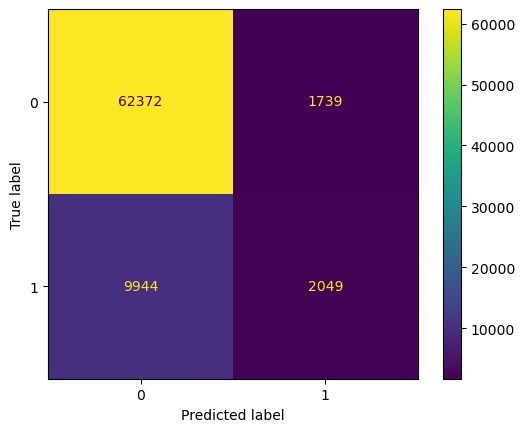

In [28]:
# Create visualisation of confusion matrix
ConfusionMatrixDisplay.from_estimator(unmodified_results['best_estimator'], X_test, y_test);

Interpretation:

    The results of the confusion matrix are as follows:

    True Negative:  62,372

    False Positive: 1,739

    False Negative: 9,944

    True Positive:  2,049    

In [29]:
# Classification Report
report_initial = classification_report(y_test, y_pred)
print(report_initial)

              precision    recall  f1-score   support

           0       0.94      0.72      0.82     64111
           1       0.33      0.74      0.46     11993

    accuracy                           0.73     76104
   macro avg       0.64      0.73      0.64     76104
weighted avg       0.84      0.73      0.76     76104



### Observations:

Looking at the errors:

For 0: 
- The precision of 0.94 means that 6% of the predicitons as not having diabetes were in fact positive.
- The recall of 0.72 means that 28% of the negative diagnosis were missed by the model as they were classified as being positive

For 1: 
- The precision of 0.33 means that 67% of the predicitons as having diabetes were in fact negative 
- The recall of 0.74 indicates that 26% of the diagnosis that were positive  were missed by the model and were classified as being negative for diabetes



The model shows a low F1 score of 0.46, indicating that the balance between recall and precision across the various classes could be improved. 

To improve the model's performance, it is recommended to closely examine instances where the sentiment was incorrectly predicted. 

Analysing these examples can help identify if there are specific health indicators that were mistakenly omitted, which could lead to more accurate predictions in the future.